In [1]:
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt

# statistics
from scipy.stats import chi2_contingency

In [2]:
# check to make sure data was imported correctly
recall_df_full = pd.read_csv("data/recalls_data.csv")
print(recall_df_full.shape)
display(recall_df_full.head())

(29572, 15)


,Report Received Date,NHTSA ID,Recall Link,Manufacturer,Subject,Component,Mfr Campaign Number,Recall Type,Potentially Affected,Recall Description,Consequence Summary,Corrective Action,Park Outside Advisory,Do Not Drive Advisory,Completion Rate % (Blank - Not Reported)
0,12/05/2025,25V838000,Go to Recall (https://www.nhtsa.gov/recalls?nh...,Ducati North America,Front or Rear Wheel May Lock Up,ELECTRICAL SYSTEM,SRV-RCL-25-004,Vehicle,1016,Ducati North America (Ducati) is recalling cer...,Front or rear wheel lockup can cause a loss of...,Dealers will inspect the fuses and fuse holder...,No,No,NaN
1,12/04/2025,25E081000,Go to Recall (https://www.nhtsa.gov/recalls?nh...,"Motorcar Parts of America, Inc.",Brake Caliper May Fracture,"SERVICE BRAKES, HYDRAULIC",NaN,Equipment,440,"Motorcar Parts of America, Inc. (MPA) is recal...",A fractured brake caliper can cause loss of br...,MPA will work with and reimburse independent t...,No,Yes,NaN
2,12/04/2025,25V837000,Go to Recall (https://www.nhtsa.gov/recalls?nh...,"BMW of North America, LLC",Air Bag May Deploy Improperly,AIR BAGS,NaN,Vehicle,25,"BMW of North America, LLC (BMW) is recalling c...",An air bag that does not deploy properly can i...,Dealers will replace the instrument panel trim...,No,No,NaN
3,12/03/2025,25V836000,Go to Recall (https://www.nhtsa.gov/recalls?nh...,"Volkswagen Group of America, Inc.",High Voltage Battery May Catch Fire,ELECTRICAL SYSTEM,93EV,Vehicle,311,"Volkswagen Group of America, Inc. (Volkswagen)...",A vehicle fire while parked or driving can inc...,Owners are advised to park outside immediately...,Yes,No,NaN
4,12/03/2025,25V835000,Go to Recall (https://www.nhtsa.gov/recalls?nh...,"Volkswagen Group of America, Inc.",Wheel May Detach from Vehicle,WHEELS,44BW,Vehicle,27,"Volkswagen Group of America, Inc. (Volkswagen)...",Incorrect wheel bolts can allow a wheel to det...,Owners are advised not to drive their vehicles...,No,Yes,NaN


In [3]:
# in our assessment, we will only use vehicle data
unique_recall_type = recall_df_full['Recall Type'].value_counts()

print(unique_recall_type)

num_unique_from_counts = len(unique_recall_type)
print(f"Number of Unique Categories (from value_counts): {num_unique_from_counts}")

Recall Type
Vehicle       25748
Equipment      2800
Tire            778
Child Seat      246
Name: count, dtype: int64
Number of Unique Categories (from value_counts): 4


In [4]:
# remove rows that are not 'vehicle' in Recall Type
recall_df = recall_df_full[recall_df_full['Recall Type'] == 'Vehicle']

print(recall_df.shape)

(25748, 15)


## Evaluate Missing Data

In [5]:
#print number of missing entries in each column
print(f'Number of Values in Dataset: {recall_df.shape[0]}')
print("Missing Entries")
print(recall_df.isna().sum())

# interpretation
# text-based columns have some missing data that needs to be managed
  # Component - 25% missing
  # Recall Description - 8.2%
  # Consequence Summary - 16.6%
  # Corrective Action - 8.1%
# completion rate has high missingness (63.6%), making it unusable for our analysis

Number of Values in Dataset: 25748
Missing Entries
Report Received Date                            0
NHTSA ID                                        0
Recall Link                                     0
Manufacturer                                    0
Subject                                         0
Component                                    6210
Mfr Campaign Number                           127
Recall Type                                     0
Potentially Affected                            0
Recall Description                           2178
Consequence Summary                          4121
Corrective Action                            2165
Park Outside Advisory                           0
Do Not Drive Advisory                           0
Completion Rate % (Blank - Not Reported)    15896
dtype: int64


In [6]:
#test whether missing values in consequence summary are independent of manufacturer using chi^2 test of independence
recall_df["missingConsequence"] = recall_df["Consequence Summary"].isna().astype(int)
missingTable = pd.crosstab(recall_df["Manufacturer"], recall_df["missingConsequence"])
chi2, p, dof, expected = chi2_contingency(missingTable)

#output results - missing values in consequence summary are not independent of manufacturer
print(f"Chi-square statistic = {chi2:.3f}")
print(f"Degrees of freedom = {dof}")
print(f"p-value = {p:.3e}")

# intrepretation of chi square result
# missing Consequences Summary values depend on manufacturer
# missingness is not random

Chi-square statistic = 9922.657
Degrees of freedom = 1845
p-value = 0.000e+00


/var/folders/sj/zjy828fx5jz4s9rfw4fsx0v40000gn/T/ipykernel_4345/2576525128.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recall_df["missingConsequence"] = recall_df["Consequence Summary"].isna().astype(int)


## Data Cleaning: Extract Dates, Assess Missingness

In [7]:
#drop any rows missing manufacturer and/or recall date from df
recall_df = recall_df.dropna(subset=['Manufacturer', 'Report Received Date'])

In [8]:
# split extraction date into month, day, and year from recall_date col
# allow for assessment of yearly and monthly trends

recall_df['Report Received Date'] = pd.to_datetime(recall_df['Report Received Date'], errors='coerce')
recall_df = recall_df.dropna(subset=['Report Received Date']) # drop rows where date conversion failed

# extract date components
recall_df['Year'] = recall_df['Report Received Date'].dt.year
recall_df['Month'] = recall_df['Report Received Date'].dt.month
recall_df['Day'] = recall_df['Report Received Date'].dt.day

# add cols for month name and day of week to aid in exploratory analysis
recall_df['Month Name'] = recall_df['Report Received Date'].dt.month_name()
recall_df['Day of Week'] = recall_df['Report Received Date'].dt.day_name()

In [9]:
# handle remaining missing vals and check again for missingness

# drop Completion Rate col - this col will be ignored in analysis due to high missingness
recall_df.drop(columns=['Completion Rate % (Blank - Not Reported)'], inplace=True)

#fill in any blank consequence summaries and component
recall_df['Consequence Summary'] = recall_df['Consequence Summary'].fillna("No description")
recall_df['Component'] = recall_df['Component'].fillna("Unknown")

recall_df.isna().sum()

Report Received Date         0
NHTSA ID                     0
Recall Link                  0
Manufacturer                 0
Subject                      0
Component                    0
Mfr Campaign Number        127
Recall Type                  0
Potentially Affected         0
Recall Description        2178
Consequence Summary          0
Corrective Action         2165
Park Outside Advisory        0
Do Not Drive Advisory        0
missingConsequence           0
Year                         0
Month                        0
Day                          0
Month Name                   0
Day of Week                  0
dtype: int64

In [10]:
# make df with only feature cols
#print(recall_df.columns.tolist())

feature_cols= ['Year', 'Month Name', 'Day of Week',
               'Manufacturer', 'Component', 'Recall Type',
               'Do Not Drive Advisory','Potentially Affected', 'Consequence Summary'
               ]
recall_df = recall_df[feature_cols]
display(recall_df)

,Year,Month Name,Day of Week,Manufacturer,Component,Recall Type,Do Not Drive Advisory,Potentially Affected,Consequence Summary
0,2025,December,Friday,Ducati North America,ELECTRICAL SYSTEM,Vehicle,No,1016,Front or rear wheel lockup can cause a loss of...
2,2025,December,Thursday,"BMW of North America, LLC",AIR BAGS,Vehicle,No,25,An air bag that does not deploy properly can i...
3,2025,December,Wednesday,"Volkswagen Group of America, Inc.",ELECTRICAL SYSTEM,Vehicle,No,311,A vehicle fire while parked or driving can inc...
4,2025,December,Wednesday,"Volkswagen Group of America, Inc.",WHEELS,Vehicle,Yes,27,Incorrect wheel bolts can allow a wheel to det...
5,2025,December,Tuesday,Zero Motorcycles Inc.,ELECTRICAL SYSTEM,Vehicle,No,7,A loss of drive power increases the risk of a ...
...,...,...,...,...,...,...,...,...,...
29567,1966,September,Thursday,Honda (American Honda Motor Co.),POWER TRAIN,Vehicle,No,18572,No description
29568,1966,September,Monday,"RENAULT, INCORPORATED","SERVICE BRAKES, HYDRAULIC",Vehicle,No,125,IF SUCH LEAKAGE OCCURS AND IF ENOUGH BRAKE FLU...
29569,1966,January,Wednesday,"General Motors, LLC",STEERING,Vehicle,No,138878,No description
29570,1966,January,Wednesday,"General Motors, LLC",STEERING,Vehicle,No,70644,No description


## Exploratory Data Analysis and Visualization
Assess trends, patterns, distribution

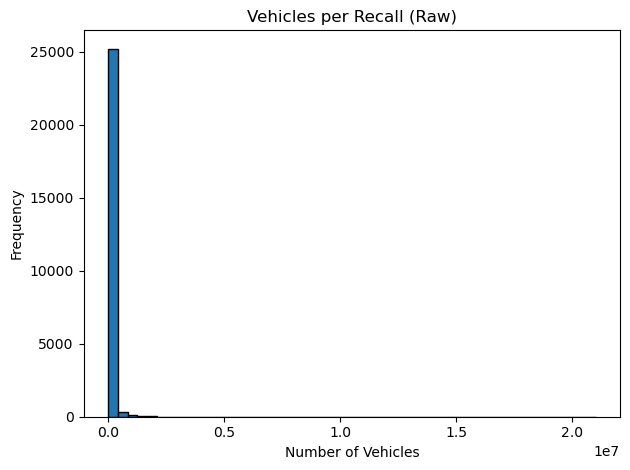

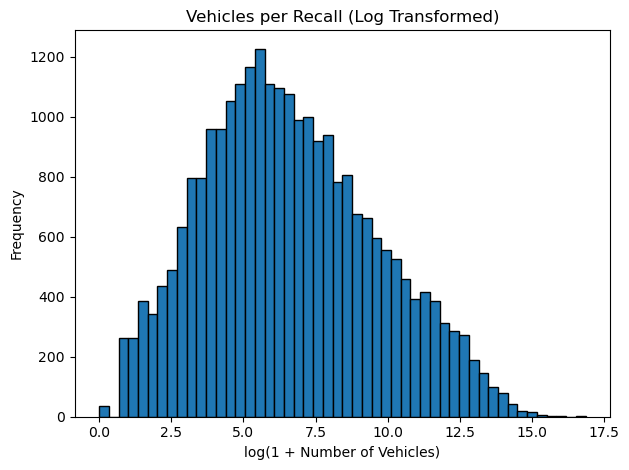

In [12]:
#Plot distribution of number of vehicles affected per recall
recall_df["Potentially Affected"].plot(kind="hist", bins = 50, edgecolor='black')
plt.title("Vehicles per Recall (Raw)")
plt.xlabel("Number of Vehicles")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

#Number vehicles per recall is right skewed, so log transform to normalize
np.log1p(recall_df["Potentially Affected"]).plot(kind="hist", bins = 50, edgecolor='black')
plt.title("Vehicles per Recall (Log Transformed)")
plt.xlabel("log(1 + Number of Vehicles)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# save log transformation in dataset and upload cleaned data to csv for clustering
recall_df["Potentially_Affected_LogTransform"] = np.log1p(recall_df["Potentially Affected"])
recall_df.to_csv('data/clean_recalls_data.csv', index=False) 


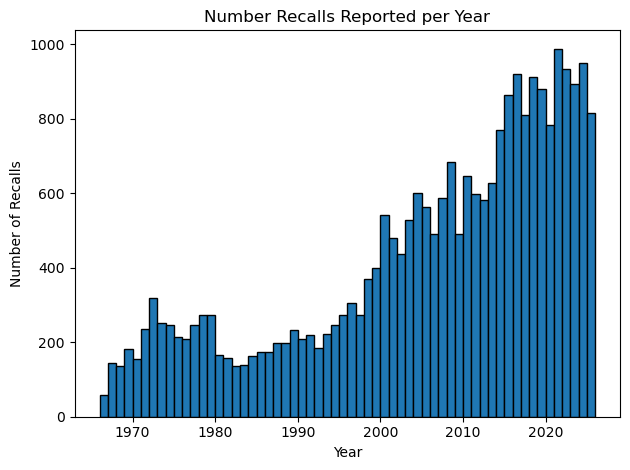

Summary of Recalls per Year:
 Average Recalls    429.133333
Median Recalls     289.000000
Min Recalls         58.000000
Max Recalls        988.000000
dtype: float64


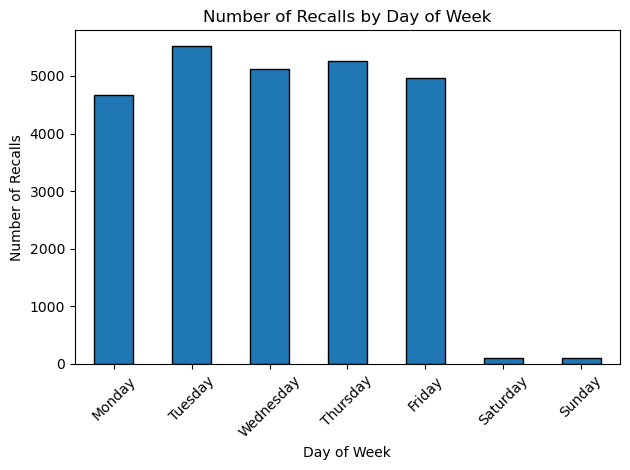

Summary of Recalls per Week Day:
 Average Recalls    3678.285714
Median Recalls     4967.000000
Min Recalls         105.000000
Max Recalls        5516.000000
dtype: float64


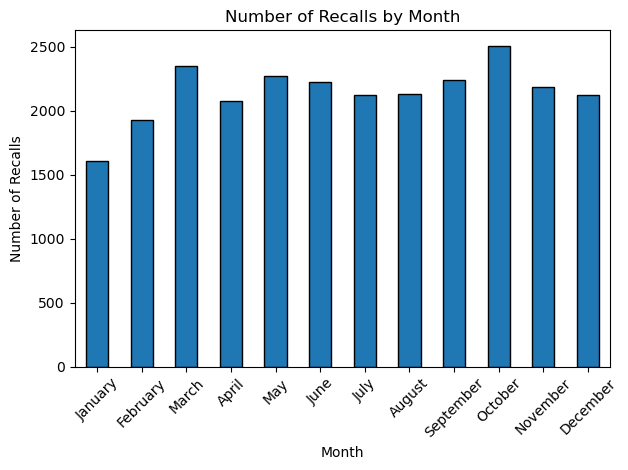

Summary of Recalls per Month:
 Average Recalls    2145.666667
Median Recalls     2159.000000
Min Recalls        1607.000000
Max Recalls        2502.000000
dtype: float64


In [13]:
# date / time trends for number of recalls

# plot number of recalls per year for entire dataset
# recalls increasing over the years - why?
# note that 2025 is low bc we do not have complete data
plt.hist(recall_df['Year'], bins=range(1966, 2027), edgecolor='black')
plt.title("Number Recalls Reported per Year")
plt.xlabel("Year")
plt.ylabel("Number of Recalls")
plt.tight_layout()
plt.show()

#Summary table: recalls per year
recalls_per_year_counts = recall_df.groupby('Year').size()
year_summary = recalls_per_year_counts.agg(['mean', 'median', 'min', 'max']).rename({'mean': 'Average Recalls', 'median': 'Median Recalls', 'min': 'Min Recalls', 'max': 'Max Recalls'})
print("Summary of Recalls per Year:\n", year_summary)

# histogram for day of week recalls
# no significant patterns found
# it is expected that recalls are announced M-F because of work week
# are recalls made on Sat / Sun very severe?
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

recall_df['Day of Week'].value_counts().reindex(day_order).plot(
    kind='bar', edgecolor='black')
plt.title("Number of Recalls by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Number of Recalls")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Summary table: recalls per day
recalls_per_day_counts = recall_df.groupby('Day of Week').size().reindex(day_order)
day_summary = recalls_per_day_counts.agg(['mean', 'median', 'min', 'max']).rename({'mean': 'Average Recalls', 'median': 'Median Recalls', 'min': 'Min Recalls', 'max': 'Max Recalls'})
print("Summary of Recalls per Week Day:\n", day_summary)


# histogram for monthly recalls
# jan and feb have lowest num of recalls announced
# march and october have the highest
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

recall_df['Month Name'].value_counts().reindex(month_order).plot(
    kind='bar', edgecolor='black')
plt.title("Number of Recalls by Month")
plt.xlabel("Month")
plt.ylabel("Number of Recalls")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Summary table: recalls per Month
recalls_per_month_counts = recall_df.groupby('Month Name').size().reindex(month_order)
month_summary = recalls_per_month_counts.agg(['mean', 'median', 'min', 'max']).rename({'mean': 'Average Recalls', 'median': 'Median Recalls', 'min': 'Min Recalls', 'max': 'Max Recalls'})
print("Summary of Recalls per Month:\n", month_summary)

                                Manufacturer  Number of Recalls
0                        General Motors, LLC               1681
1                         Ford Motor Company               1637
2                     Chrysler (FCA US, LLC)               1418
3                         Forest River, Inc.                612
4          Volkswagen Group of America, Inc.                580
5                  BMW of North America, LLC                565
6          Daimler Trucks North America, LLC                525
7                     Mercedes-Benz USA, LLC                488
8           Honda (American Honda Motor Co.)                446
9                 Nissan North America, Inc.                430
10                         Mack Trucks, Inc.                420
11                       PACCAR Incorporated                411
12                    Blue Bird Body Company                397
13                 International Motors, LLC                396
14                          FREIGHTLINER

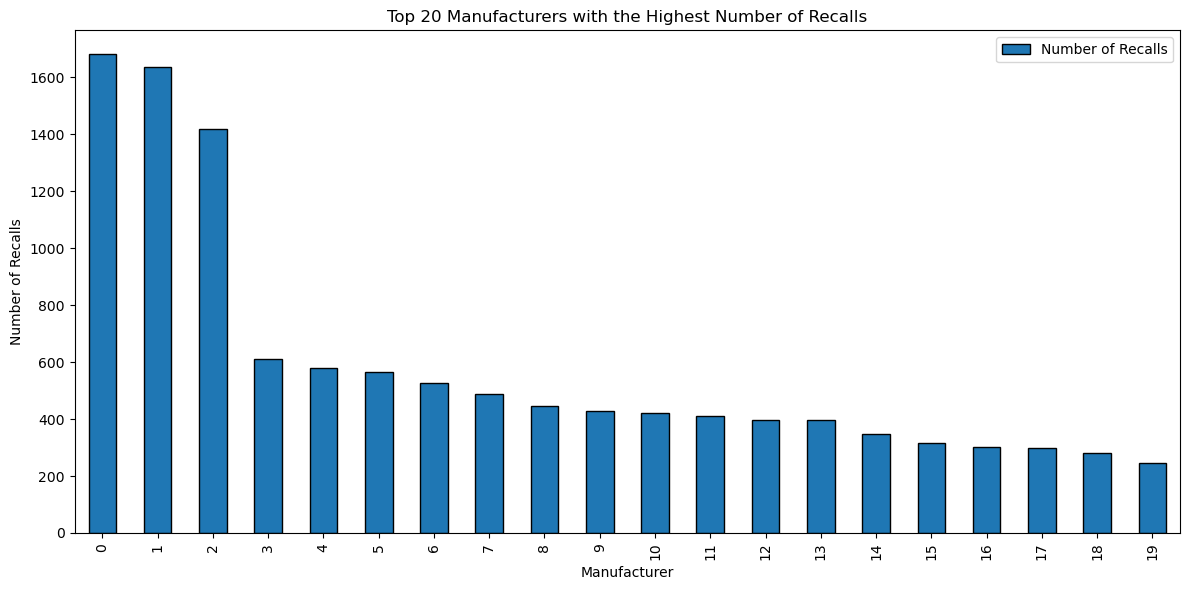

In [14]:
#Number of Recalls per Manufacturer
recalls_per_manufacturer = recall_df.groupby('Manufacturer').size().sort_values(ascending=False).reset_index(name='Number of Recalls')
print(recalls_per_manufacturer.head(20))

#plot recalls per manufacturer
top_n = 20
recalls_per_manufacturer.head(top_n).plot(kind='bar', edgecolor='black', figsize=(12,6))
plt.title('Top 20 Manufacturers with the Highest Number of Recalls')
plt.xlabel('Manufacturer')
plt.ylabel('Number of Recalls')
plt.tight_layout()
plt.show()

                                                   mean    median    min  \
Manufacturer                                                               
Harbor Freight Tools                      234778.000000  234778.0  95237   
Toyota Motor Engineering & Manufacturing  226760.838710   37684.0      2   
Honda (American Honda Motor Co.)          178050.245495   11556.5      0   
Tesla, Inc.                               156266.904762    7444.5      1   
Ford Motor Company                        136556.285537    9400.0      1   
General Motors, LLC                       122153.197612    6083.0      0   
Chrysler (FCA US, LLC)                    102248.867804    7400.0      1   
Nissan North America, Inc.                102169.096019   15223.0      2   
Hyundai Motor America                      98185.884058   17803.5      2   
Subaru of America, Inc.                    87364.284884   26371.0      5   
Kia America, Inc.                          83494.409091   26416.0      1   
Toyota Motor

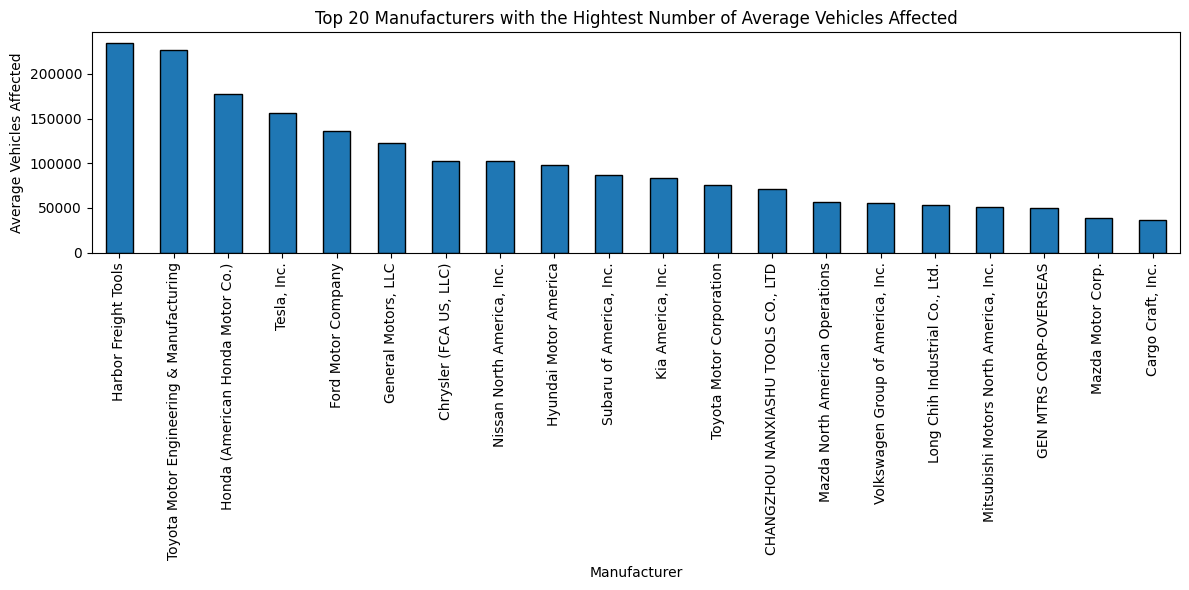

In [ ]:
#Vehicles Affected per Manufacturer
vehicles_per_manufacturer = recall_df.groupby('Manufacturer')['Potentially Affected'].agg(['mean','median','min','max']).sort_values('mean', ascending=False)
print(vehicles_per_manufacturer.head(20))

#plot of average vehicles affected for the top 20 manufacturers
vehicles_per_manufacturer['mean'].head(top_n).plot(kind='bar', edgecolor='black', figsize=(12,6))
plt.title('Top 20 Manufacturers with the Hightest Number of Average Vehicles Affected')
plt.xlabel('Manufacturer')
plt.ylabel('Average Vehicles Affected')
plt.tight_layout()
plt.show()
